# Implementações

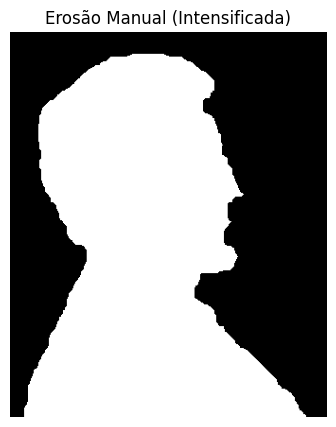

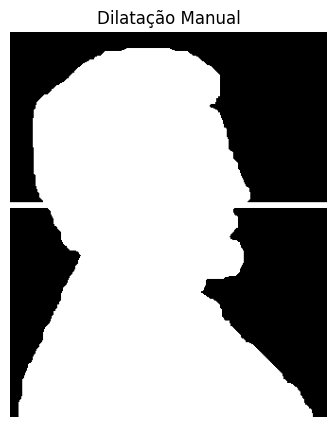

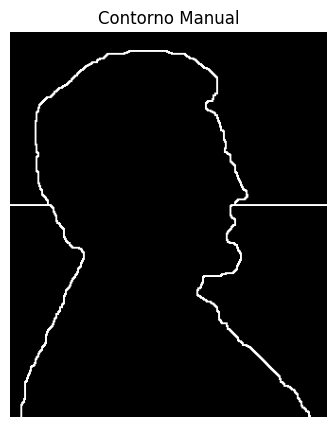

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Função de erosão manual com múltiplas iterações
def erosao_manual(imagem, kernel, iteracoes=1):
    img_h, img_w = imagem.shape
    kernel_h, kernel_w = kernel.shape
    
    # Padding para aplicar o kernel nas bordas
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    
    # Inicializando a imagem erodida com a imagem original
    img_erodida = imagem.copy()

    for _ in range(iteracoes):
        # Adiciona padding
        imagem_padded = np.pad(img_erodida, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=255)
        img_temp = np.zeros_like(imagem)  # Temporária para esta iteração

        for i in range(pad_h, img_h + pad_h):
            for j in range(pad_w, img_w + pad_w):
                # Região da imagem que corresponde ao kernel
                regiao = imagem_padded[i-pad_h:i+pad_h+1, j-pad_w:j+pad_w+1]
                # Se todos os elementos da região forem 255 onde o kernel é 1, mantemos o pixel branco
                if np.all(regiao[kernel == 1] == 255):
                    img_temp[i-pad_h, j-pad_w] = 255

        img_erodida = img_temp  # Atualiza para a próxima iteração
    
    return img_erodida

# Função de dilatação manual
def dilatacao_manual(imagem, kernel):
    img_h, img_w = imagem.shape
    kernel_h, kernel_w = kernel.shape
    
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2
    imagem_padded = np.pad(imagem, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    
    img_dilatada = np.zeros_like(imagem)
    
    for i in range(pad_h, img_h + pad_h):
        for j in range(pad_w, img_w + pad_w):
            regiao = imagem_padded[i-pad_h:i+pad_h+1, j-pad_w:j+pad_w+1]
            if np.any(regiao[kernel == 1] == 255):
                img_dilatada[i-pad_h, j-pad_w] = 255
    
    return img_dilatada

# Função de extração de contorno
def extracao_de_contorno(imagem, kernel):
    img_erodida = erosao_manual(imagem, kernel)
    contorno = imagem - img_erodida
    return contorno

# Função para exibir e salvar as imagens
def plot_and_save_image(imagem, title, filename):
    plt.figure(figsize=(5,5))
    plt.imshow(imagem, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.savefig(os.path.join('imgs', filename), bbox_inches='tight', pad_inches=0)
    plt.show()

# Exemplo de uso
img = cv2.imread('imgs/imagea.png', 0)  # Carrega imagem em modo grayscale
img[img > 127] = 255  # Normaliza para binário
img[img <= 127] = 0

# Definindo um kernel maior (5x5)
kernel = np.ones((5, 5), np.uint8)

# Aplica a erosão com mais iterações para aumentar o efeito
img_erodida = erosao_manual(img, kernel, iteracoes=2)
plot_and_save_image(img_erodida, 'Erosão Manual (Intensificada)', 'erosao_manual_intensificada.png')

# Aplica a dilatação
img_dilatada = dilatacao_manual(img, kernel)
plot_and_save_image(img_dilatada, 'Dilatação Manual', 'dilatacao_manual.png')

# Aplica a extração de contornos
contorno_img = extracao_de_contorno(img, kernel)
plot_and_save_image(contorno_img, 'Contorno Manual', 'contorno_manual.png')


## Limiarização Usando o Método do Vale

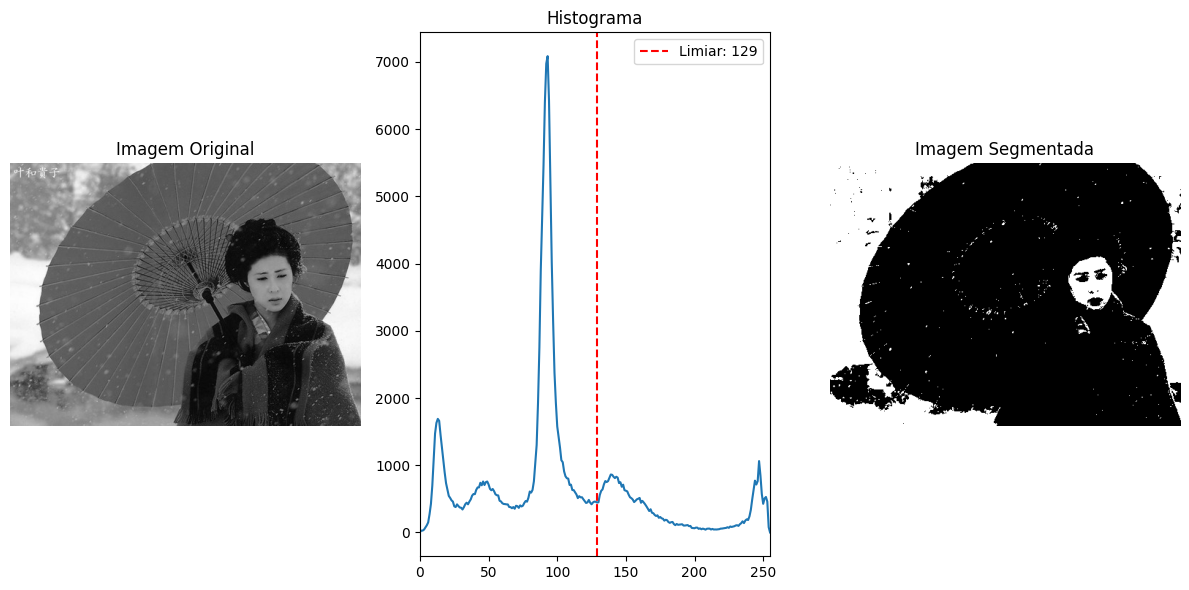

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def encontrar_vale(histograma):
    # Encontrar a derivada do histograma
    derivada = np.diff(histograma)
    
    # Identificar os pontos onde a derivada muda de negativa para positiva
    vales = np.where((derivada[:-1] < 0) & (derivada[1:] > 0))[0] + 1
    
    # Se houver vales, escolher o mais próximo do meio do intervalo de níveis de cinza
    if len(vales) > 0:
        meio = len(histograma) // 2
        vale_mais_proximo = min(vales, key=lambda x: abs(x - meio))
        return vale_mais_proximo
    else:
        return None

def segmentacao_por_limiarizacao(imagem):
    # Converter a imagem para escala de cinza
    imagem_gray = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    
    # Calcular o histograma da imagem
    histograma, _ = np.histogram(imagem_gray.flatten(), bins=256, range=[0, 256])
    
    limiar = encontrar_vale(histograma)
    
    _, imagem_segmentada = cv2.threshold(imagem_gray, limiar, 255, cv2.THRESH_BINARY)
    
    return imagem_gray, histograma, limiar, imagem_segmentada

# Carregar a imagem
imagem = cv2.imread('imgs/eiffel.jpg')  # Substitua pelo caminho da sua imagem

# Aplicar a segmentação
imagem_gray, histograma, limiar, imagem_segmentada = segmentacao_por_limiarizacao(imagem)

# Exibir os resultados
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Imagem Original')
plt.imshow(cv2.cvtColor(imagem_gray, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Histograma')
plt.plot(histograma)
plt.axvline(x=limiar, color='r', linestyle='--', label='Limiar: {}'.format(limiar))
plt.legend()
plt.xlim([0, 255])

plt.subplot(1, 3, 3)
plt.title('Imagem Segmentada')
plt.imshow(imagem_segmentada, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
